In [2]:
%pylab inline
from bs4 import BeautifulSoup
import requests
import os
import glob
from tqdm import tqdm
import shutil
from pywsi.io.operations import path_leaf
from skimage.io import imread, imsave
from skimage.color import gray2rgb
import pandas as pd
from pywsi.stats import welford_simulatenous_update
download_dir  = '/Z/personal-folders/interns/saket/strand_emp_images'

Populating the interactive namespace from numpy and matplotlib


/home/saket/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['imread', 'imsave']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Download Data

In [ ]:
data = requests.get('https://strandls.com/strand-management-team/')
soup = BeautifulSoup(data.content)

os.makedirs(download_dir, exist_ok=True)
os.makedirs(download_dir+'/128px', exist_ok=True)
os.makedirs(download_dir+'/64px', exist_ok=True)
os.makedirs(download_dir+'/160px', exist_ok=True)


# Copy to local dir

In [ ]:

for url in soup.find_all('img', {'style': "opacity: 1;"}):
    src = url.attrs['src']
    r = requests.get(src, stream=True)
    path = os.path.join(download_dir, path_leaf(src))
    if r.status_code == 200:
        with open(path, 'wb') as f:
            r.raw.decode_content = True
            shutil.copyfileobj(r.raw, f)        

# Make Xpx thumbnails

In [ ]:
for f in glob.glob(download_dir+'/*.jpg'):
    name = path_leaf(f)
    os.system('convert {} -resize 128x128 {}/128px/{}'.format(f, download_dir, name))
    

In [ ]:
for f in glob.glob(download_dir+'/*.jpg'):
    name = path_leaf(f)
    os.system('convert {} -resize 64x64 {}/64px/{}'.format(f, download_dir, name))
    

In [ ]:
for f in glob.glob(download_dir+'/128px/*.jpg'):
    name = path_leaf(f)
    name = name.replace('.jpg', '')
    #if 'team' not in name:
    os.makedirs(download_dir+'/128px/'+name)
    shutil.copy(f, download_dir+'/128px/'+name)
    

In [ ]:
for f in glob.glob(download_dir+'/*.jpg'):
    name = path_leaf(f)
    os.system('convert {} -resize 160x160 {}/160px/{}'.format(f, download_dir, name))
    

In [ ]:
for f in glob.glob(download_dir+'/160px/*.jpg'):
    name = path_leaf(f)
    name = name.replace('.jpg', '')
    #if 'team' not in name:
    os.makedirs(download_dir+'/160px/'+name)
    shutil.copy(f, download_dir+'/160px/'+name)

# Display images

In [3]:
n_images = 0
images = []
names = []
for f in glob.glob(download_dir+'/160px/*.jpg'):
    name = path_leaf(f)
    names.append(name)
    name_x = name.replace('.jpg', '')
    #if 'team' not in name:        
    os.makedirs(download_dir+'/160px_3channel/'+name_x, exist_ok=True)
    out_path = download_dir+'/160px_3channel/'+name_x+'/'+name
    img = gray2rgb(imread(f))
    images.append(img)
    imsave(out_path, img)

    n_images += 1

In [5]:
#grid = 5*4
image_size = 160
bw = 3
shape = (8, 4)

grid = np.zeros((5*image_size, 4*image_size), np.float32)
img = np.zeros((shape[1]*(img_size+bw)+bw, shape[0]*(img_size+bw)+bw, 3), np.uint8)

nrof_images = shape[1]
#images.shape[0]


for col in range(shape[1]):
    x_start = col*(img_size+bw)+bw
    for row in range(shape[0]):
        img_index = col*shape[0]+row
        y_start = row*(img_size+bw)+bw
        if img_index < len(images):
            img[x_start:x_start+img_size, y_start:y_start+img_size, :] = images[img_index]
        

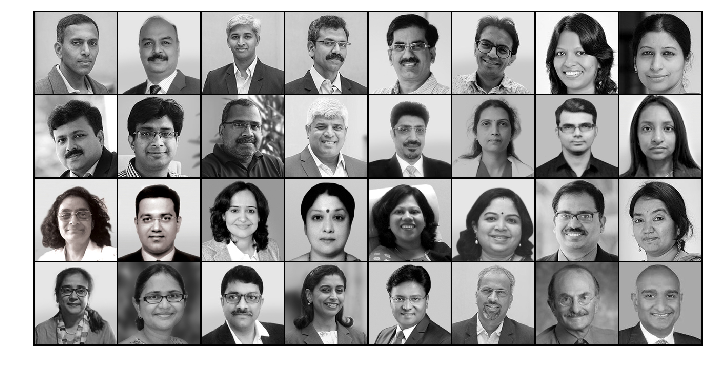

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_axis_off()
ax.imshow(img, cmap='gray')
fig.tight_layout()

# Edit celeb_attributes

In [ ]:
df = pd.read_table('../../facenet/my-data/Strand_emp_attributes.tsv')
df = df.rename(columns={'Unnamed: 0': 'filename'})
df2 = pd.read_table('../../facenet/my-data/list_attr_celeba_fixedspace.txt',
                  sep=' ', skiprows=[0])
df2 = df2.set_index('filename')


In [ ]:
df = df.T
df.columns = df.iloc[0]
df = df.iloc[1:,]
df3 = pd.concat([df2, df])
#df = df.rename(columns={'Unnamed: 0': 'filename'})
df3.to_csv('../../facenet/my-data/list_attr_celeba_strand.txt', sep= ' ')

In [ ]:
celeba_dir = '/Z/personal-folders/interns/saket/github/facenet/my-data/CelebA/Img/img_align_celeba/'
aligned_dir = '/Z/personal-folders/interns/saket/strand_emp_images_mtcnnpy_160_3channel/'
#for f in glob.glob(download_dir+'/160px_3channel/*/*.jpg'):
for f in glob.glob(aligned_dir+'/*/*.jpg'):
    name = path_leaf(f)
    
    #os.symlink(f, os.path.join(celeba_dir, name))
    #"""
    #try:
    #    os.unlink(os.path.join(celeba_dir, name))
    #except FileNotFoundError:
    #    print(f)
    #    pass
    #"""
    

# Caclulate average vector

In [3]:
aligned_dir = '/Z/personal-folders/interns/saket/strand_celeba_mtcnnpy_160/'
for index, f in enumerate(tqdm(glob.glob(aligned_dir+'*/*.png'))):
    count = index+1
    image = imread(f)
    shape = image.shape
    vector = np.mean(image.reshape(shape[0]*shape[1], shape[2]), axis=0)
    if count == 1:
        avg = vector
        M2 = np.zeros(len(vector))
    avg, M2, var, samplevar = welford_simulatenous_update(avg, M2, vector, count)

    #print(image.shape)
    #break


100%|██████████| 202313/202313 [24:19<00:00, 138.60it/s]


In [4]:
avg

array([137.26998354, 104.68044217,  88.26236322])

In [5]:
samplevar

array([852.56199093, 677.80876898, 655.78381183])

In [6]:
var

array([852.55777686, 677.80541868, 655.7805704 ])